In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import cv2

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [38]:
def preprocess_image(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Apply median blur to reduce noise
    blurred = cv2.medianBlur(gray, 5)
    # Optional: Adaptive Thresholding for better contrast
    # binary = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2)
    return blurred, gray

In [39]:
def hough_circle_detection(image, dp, minDist, param1, param2, minRadius, maxRadius):
    circles = cv2.HoughCircles(
        image,
        cv2.HOUGH_GRADIENT,
        dp=dp,
        minDist=minDist,
        param1=param1,
        param2=param2,
        minRadius=minRadius,
        maxRadius=maxRadius
    )
    return circles

# Grid for Regional Analysis

In [40]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import math

# Configuration Parameters
IMAGE_PATH = '/content/drive/MyDrive/Planetary/64ppd.png'
RESOLUTION_PPD = 64  # pixels per degree
GRID_ROWS = 4  # Number of rows in the grid
GRID_COLS = 4  # Number of columns in the grid

# Load Image
image = cv2.imread(IMAGE_PATH)
height, width, _ = image.shape

# Define Grid
def define_grid(width, height, rows, cols):
    grid = []
    row_height = height // rows
    col_width = width // cols
    for r in range(rows):
        for c in range(cols):
            x_start = c * col_width
            y_start = r * row_height
            x_end = (c + 1) * col_width if c < cols -1 else width
            y_end = (r + 1) * row_height if r < rows -1 else height
            grid.append((x_start, y_start, x_end, y_end))
    return grid

grid = define_grid(width, height, GRID_ROWS, GRID_COLS)

# Function to Detect Craters in a Subsection
def detect_craters(sub_image, params):
    blur, _ = preprocess_image(sub_image)
    circles = hough_circle_detection(blur, *params)
    if circles is not None:
        circles = np.round(circles[0, :]).astype("int")
    return circles

# Function to Calculate Crater Density
def calculate_crater_density(circles, area):
    return len(circles) / area if circles is not None else 0

# Function to Calculate Area in Degrees
def calculate_area(grid_section):
    # Convert pixel counts to degrees
    x_start, y_start, x_end, y_end = grid_section
    lon_diff = (x_end - x_start) / RESOLUTION_PPD
    lat_diff = (y_end - y_start) / RESOLUTION_PPD
    return lon_diff * lat_diff  # degrees squared

# Initialize Data Structures
crater_data = []

# Iterate Over Grid Sections
for idx, section in enumerate(grid):
    x_start, y_start, x_end, y_end = section
    sub_image = image[y_start:y_end, x_start:x_end]

    # Define Parameter Sets (You can customize or optimize these)
    params = (1.2, 27, 140, 40, 1, 40)

    # Detect Craters
    circles = detect_craters(sub_image, params)

    # Calculate Area
    area = calculate_area(section)

    # Calculate Density
    density = calculate_crater_density(circles, area)

    # Store Data
    crater_data.append({
        'grid_index': idx,
        'crater_count': len(circles) if circles is not None else 0,
        'crater_density': density,
        'craters': circles
    })

# Example Output
for data in crater_data:
    print(f"Grid {data['grid_index']}: Crater Count = {data['crater_count']}, Density = {data['crater_density']:.2f} craters/deg²")


Grid 0: Crater Count = 4, Density = 0.04 craters/deg²
Grid 1: Crater Count = 4, Density = 0.04 craters/deg²
Grid 2: Crater Count = 11, Density = 0.10 craters/deg²
Grid 3: Crater Count = 52, Density = 0.49 craters/deg²
Grid 4: Crater Count = 5, Density = 0.05 craters/deg²
Grid 5: Crater Count = 13, Density = 0.12 craters/deg²
Grid 6: Crater Count = 7, Density = 0.07 craters/deg²
Grid 7: Crater Count = 35, Density = 0.33 craters/deg²
Grid 8: Crater Count = 9, Density = 0.08 craters/deg²
Grid 9: Crater Count = 16, Density = 0.15 craters/deg²
Grid 10: Crater Count = 20, Density = 0.19 craters/deg²
Grid 11: Crater Count = 83, Density = 0.78 craters/deg²
Grid 12: Crater Count = 0, Density = 0.00 craters/deg²
Grid 13: Crater Count = 5, Density = 0.05 craters/deg²
Grid 14: Crater Count = 59, Density = 0.55 craters/deg²
Grid 15: Crater Count = 28, Density = 0.26 craters/deg²


# Visualizing Crater Density Across the Region

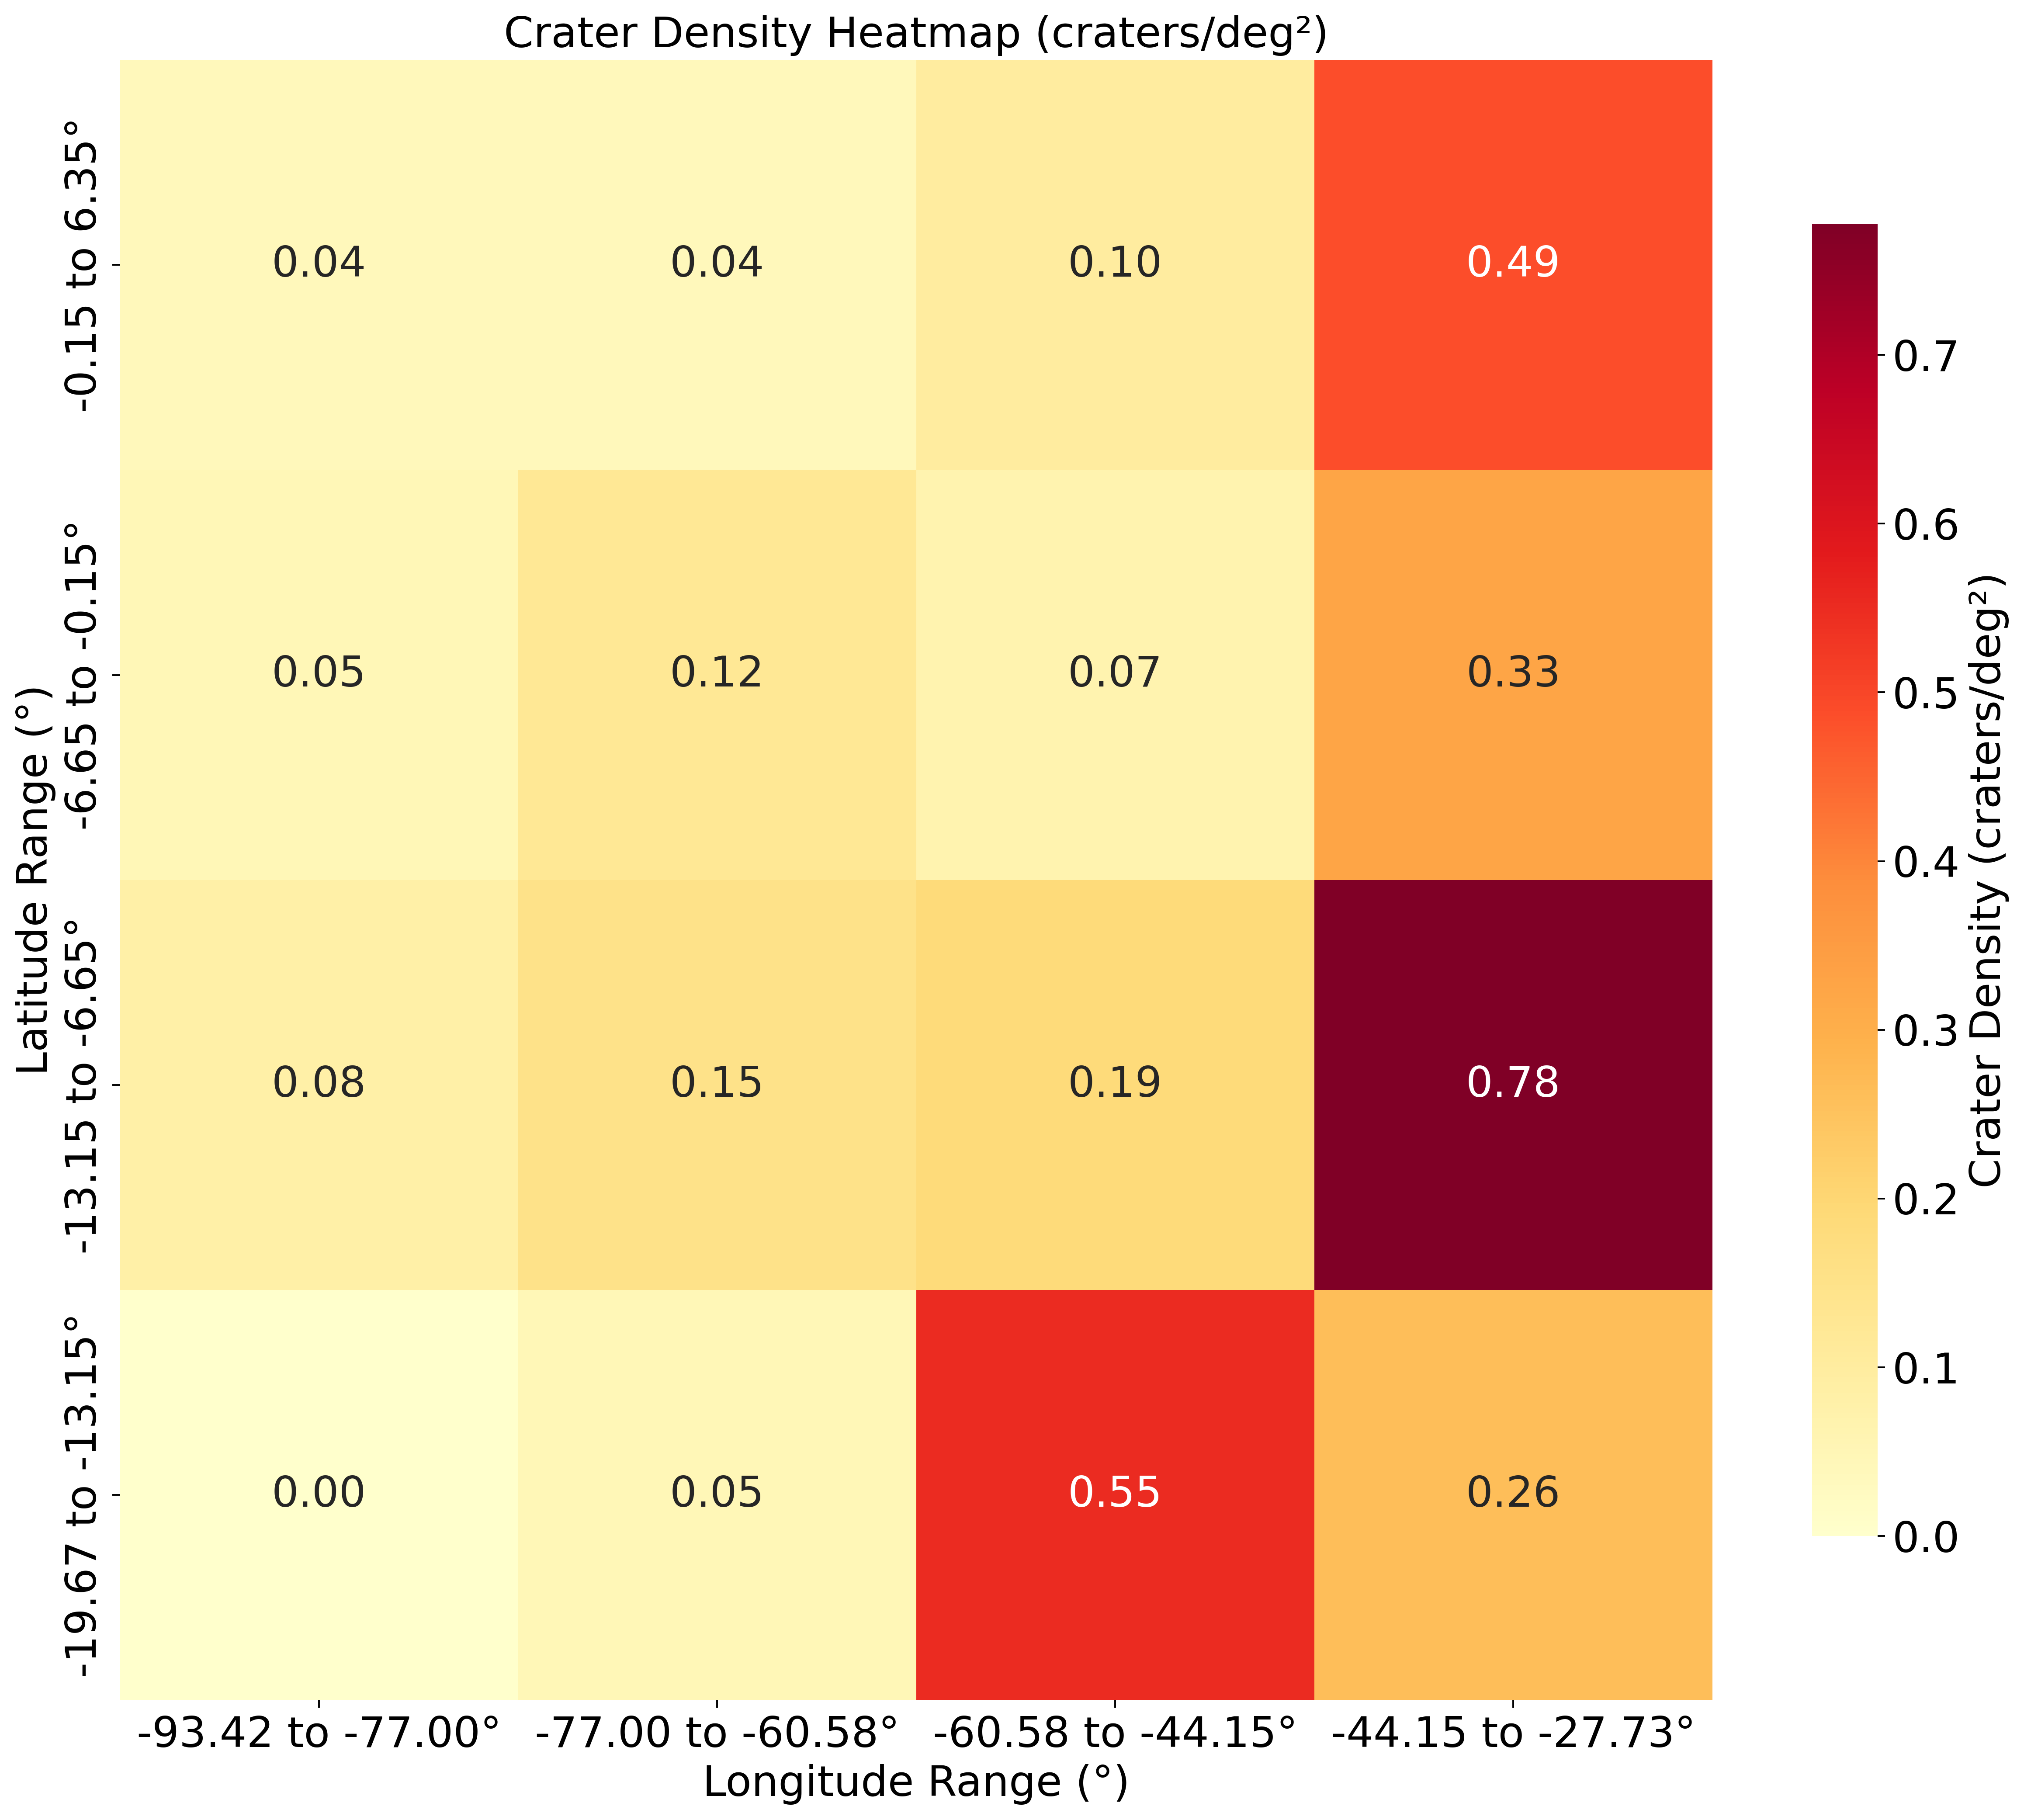

In [41]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Assuming the values for grid and crater_data are already defined in your script
# top_left, bottom_left, top_right, bottom_right, grid, crater_data, RESOLUTION_PPD, GRID_ROWS, GRID_COLS are defined

top_left = (-93.42, 6.35)
bottom_left = (-93.42, -19.58)
top_right = (27.77, 6.35)
bottom_right = (27.77, -19.58)

# Function to calculate latitude and longitude for grid sections
def calculate_lat_lon_ranges(grid, resolution_ppd):
    lat_lon_ranges = []
    for section in grid:
        x_start, y_start, x_end, y_end = section
        lon_start = top_left[0] + (x_start / resolution_ppd)
        lon_end = top_left[0] + (x_end / resolution_ppd)
        lat_start = top_left[1] - (y_end / resolution_ppd)  # Negative because image Y decreases upwards
        lat_end = top_left[1] - (y_start / resolution_ppd)
        lat_lon_ranges.append((lon_start, lon_end, lat_start, lat_end))
    return lat_lon_ranges

# Calculate latitude and longitude ranges for the heatmap labels
lat_lon_ranges = calculate_lat_lon_ranges(grid, RESOLUTION_PPD)

# Prepare Data for Heatmap
densities = [data['crater_density'] for data in crater_data]  # Use 'crater_density'

# Reshape Data for Heatmap
heatmap_data = np.array(densities).reshape(GRID_ROWS, GRID_COLS)

# Create Heatmap
plt.figure(figsize=(14, 12), dpi=350)  # Increase figure size and set dpi to 350
ax = sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap='YlOrRd',
            xticklabels=[f"{lat_lon_ranges[i][0]:.2f} to {lat_lon_ranges[i][1]:.2f}°" for i in range(GRID_COLS)],
            yticklabels=[f"{lat_lon_ranges[i][2]:.2f} to {lat_lon_ranges[i][3]:.2f}°" for i in range(0, GRID_ROWS*GRID_COLS, GRID_COLS)],
            annot_kws={"size": 20},  # Increase annotation font size
            cbar_kws={"label": "Crater Density (craters/deg²)", 'shrink': 0.8})  # Color bar label and shrink

# Adjusting axis labels and title
plt.title('Crater Density Heatmap (craters/deg²)', fontsize=20)
plt.xlabel('Longitude Range (°)', fontsize=20)
plt.ylabel('Latitude Range (°)', fontsize=20)

# Adjust tick parameters for larger font size
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# Adjust the colorbar labels and ticks
cbar = ax.collections[0].colorbar  # Get the colorbar
cbar.set_label('Crater Density (craters/deg²)', fontsize=20)  # Set colorbar label
cbar.ax.tick_params(labelsize=20)  # Set colorbar ticks font size

# Adjust layout to prevent overlap and make the figure look neat
plt.tight_layout()

# Show the plot
plt.show()


# Analyzing Crater Size Distribution per Grid

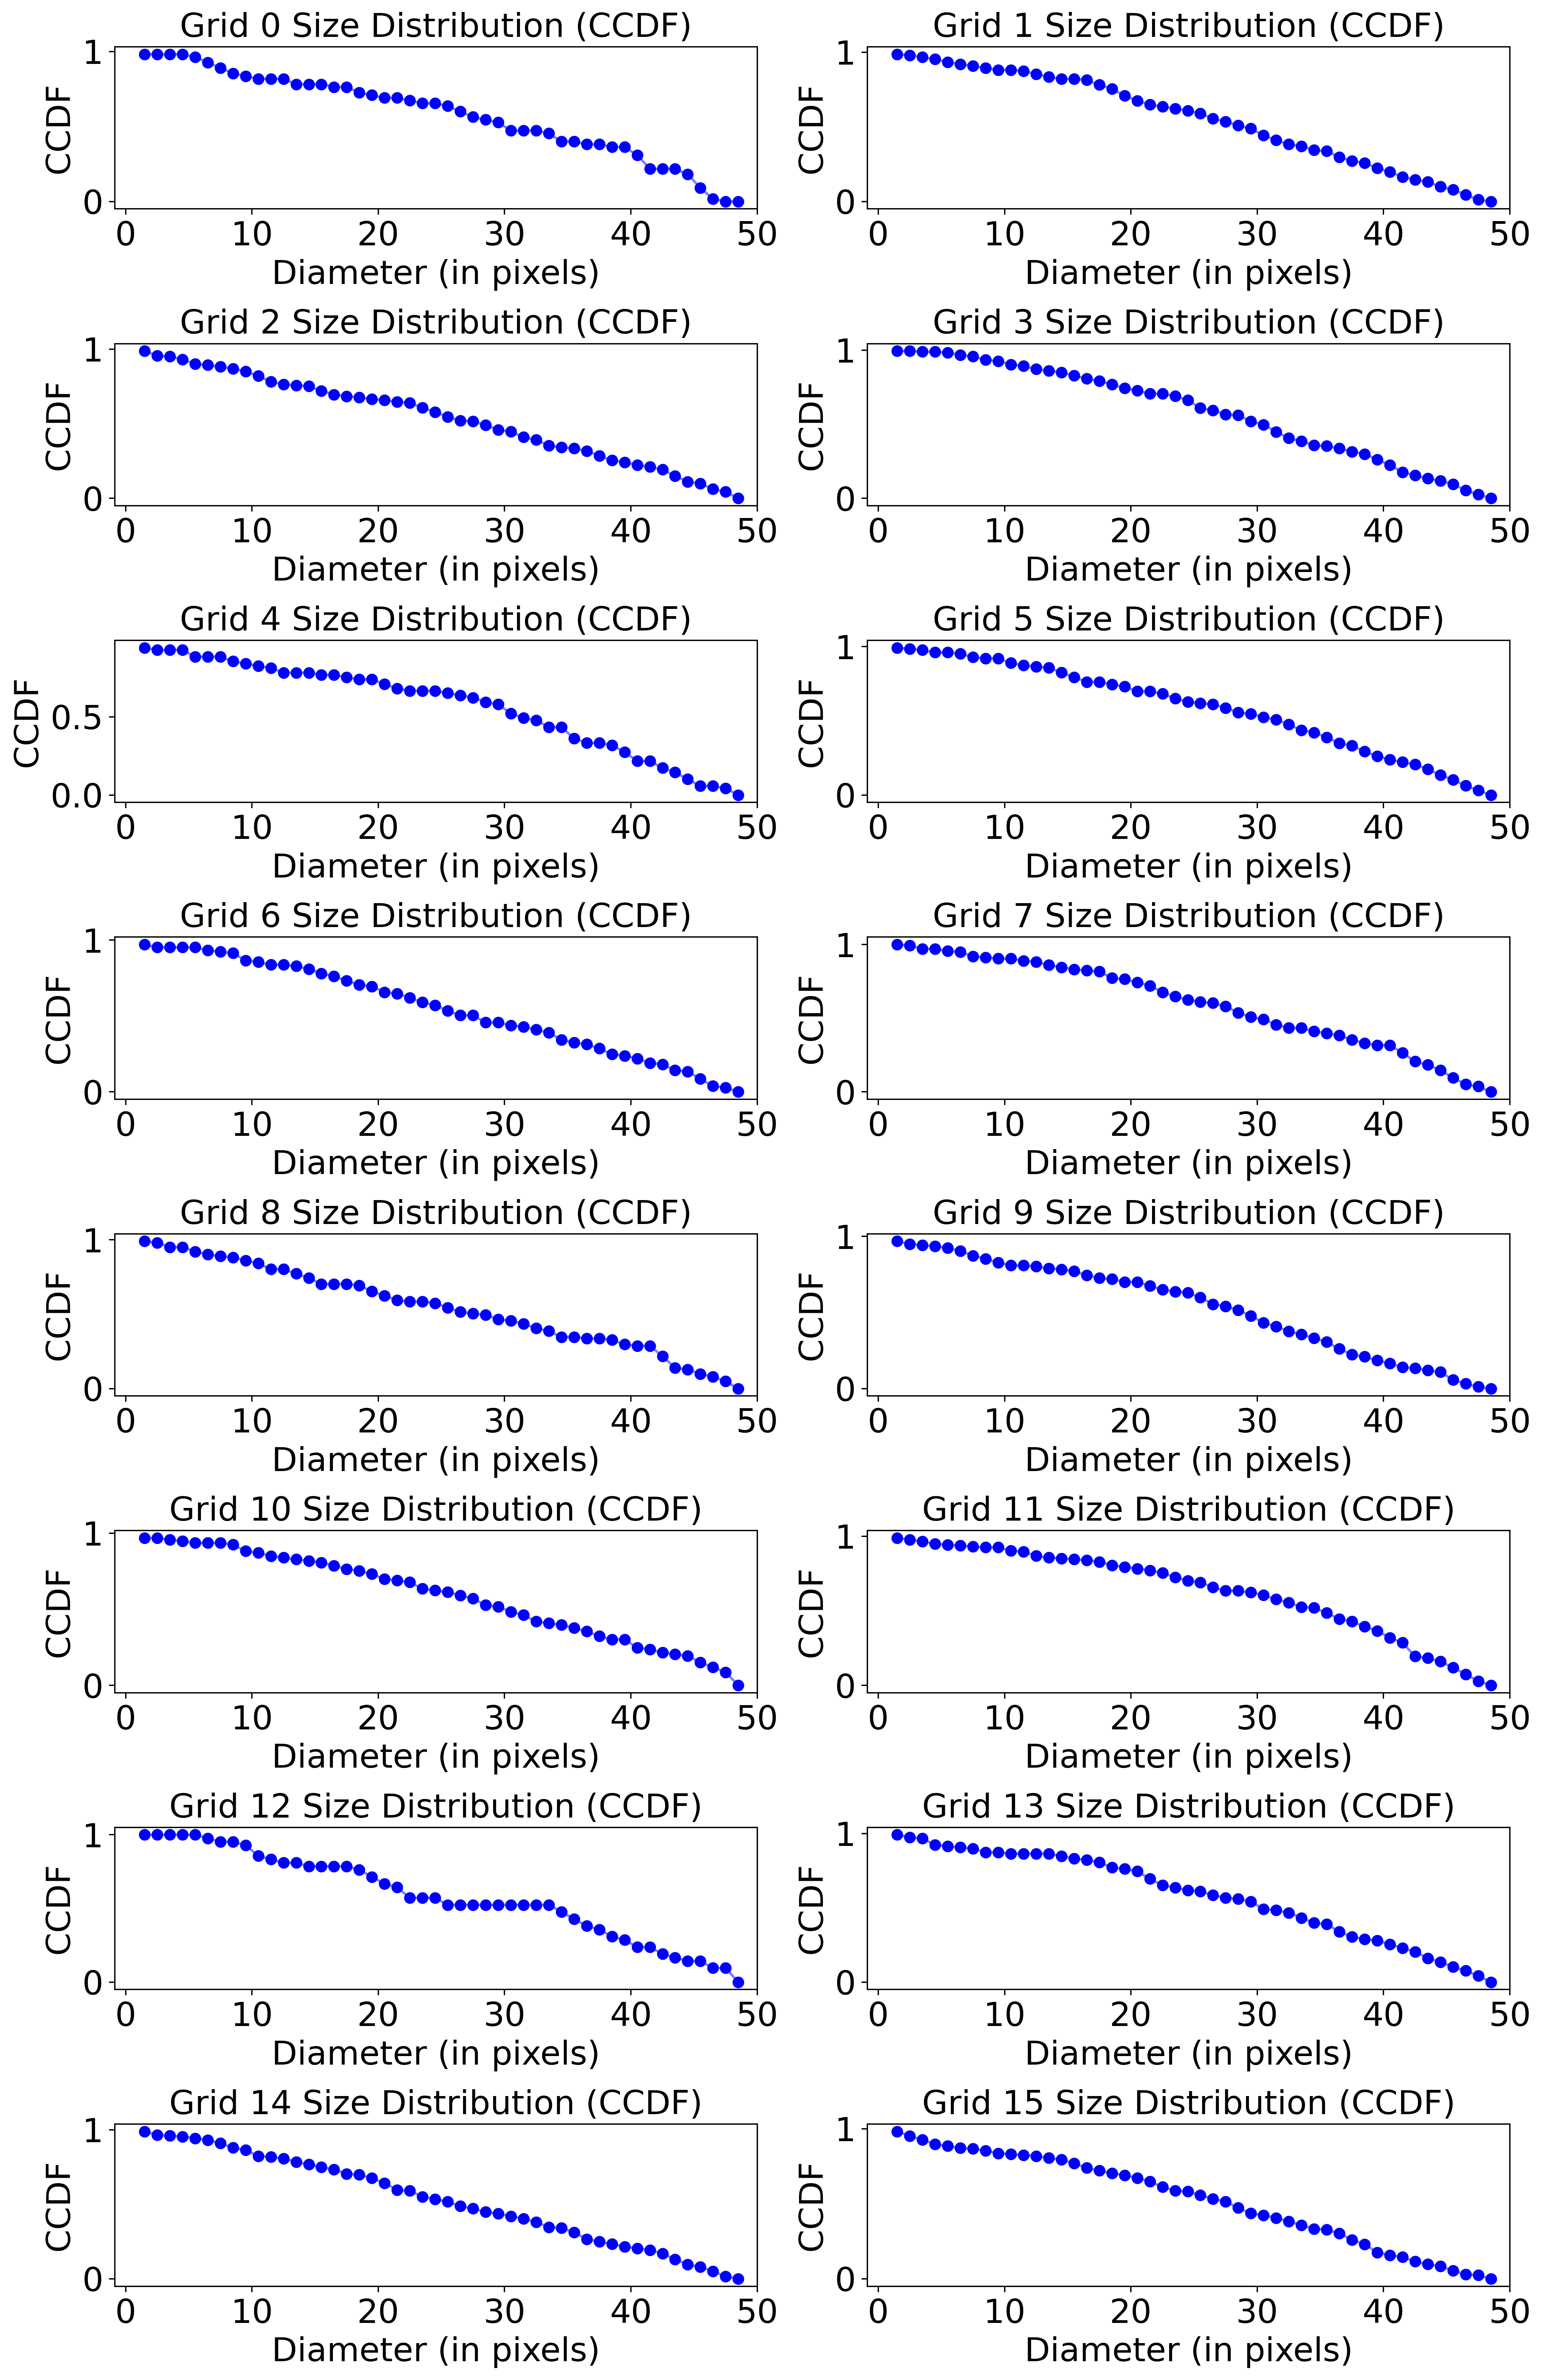

In [59]:
import matplotlib.pyplot as plt
import numpy as np

def plot_size_distribution(crater_data, grid_rows, grid_cols):
    # Create figure with 8 rows and 2 columns, increasing figure size
    fig, axes = plt.subplots(grid_rows, grid_cols, figsize=(13, 20), dpi=350)  # 8x2 grid and increased DPI
    axes = axes.flatten()

    for idx, data in enumerate(crater_data):
        ax = axes[idx]
        circles = data.get('craters')  # Use 'craters' instead of 'craters_optimized'

        # Initialize diameters list
        diameters = []

        if circles is not None and len(circles) > 0:  # Check if circles are detected
            for circle in circles:
                # Each circle is an array [x, y, radius]
                if len(circle) == 3:  # Ensure that we have x, y, and radius
                    diameter = 2 * circle[2]  # Calculate diameter from radius
                    diameters.append(diameter)

        if diameters:  # Only plot if there are diameters
            # Calculate histogram
            counts, bin_edges = np.histogram(diameters, bins=range(1, 50), density=True)

            # Calculate cumulative distribution
            cumulative = np.cumsum(counts) * np.diff(bin_edges)

            # Calculate 1 - cumulative distribution (CCDF)
            ccdf = 1 - np.concatenate(([0], cumulative))

            # Prepare bin centers for plotting (single value for each bin)
            bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])

            # Plot the CCDF as a scatter plot with connecting lines, only using one point per bin
            ax.scatter(bin_centers, ccdf[1:], color='blue', label='CCDF', zorder=2)
            ax.plot(bin_centers, ccdf[1:], color='blue', alpha=0.5)  # Connect the points

            ax.set_title(f"Grid {idx} Size Distribution (CCDF)", fontsize=20)
            ax.set_xlabel("Diameter (in pixels)", fontsize=20)
            ax.set_ylabel("CCDF", fontsize=20)

        else:
            ax.text(0.5, 0.5, 'No Craters Detected', horizontalalignment='center',
                    verticalalignment='center', transform=ax.transAxes)
            ax.set_title(f"Grid {idx} Size Distribution", fontsize=20)
            ax.set_xlabel("Diameter (pixels)", fontsize=20)
            ax.set_ylabel("Count", fontsize=20)

        # Set font size for ticks
        ax.tick_params(axis='both', labelsize=20)

        # Increase x-axis width by extending the limits (you can increase by a factor of 1.25 for example)
        xlim = ax.get_xlim()
        ax.set_xlim([xlim[0], xlim[0] + 0.75 * (xlim[1] - xlim[0])])  # Increase x-axis width by 25%

        # Set specific x-ticks (0, 10, 20, 30, 40)
        ax.set_xticks([0, 10, 20, 30, 40, 50])

    # Adjust the spacing between subplots
    plt.subplots_adjust(hspace=0.5, wspace=0.3)  # Adjust horizontal and vertical spacing
    plt.tight_layout()  # Tight layout for better spacing
    plt.show()

# Plot Size Distributions
plot_size_distribution(crater_data, grid_rows=8, grid_cols=2)


# Exporting Crater Data for Further Analysis

In [43]:


import csv

# Function to Convert Pixel to Geographic Coordinates
def pixel_to_geo(pixel_x, pixel_y, grid_section, resolution_ppd):
    x_start, y_start, _, _ = grid_section
    lon = top_left[0] + ((x_start + pixel_x) / resolution_ppd)
    lat = top_left[1] - ((y_start + pixel_y) / resolution_ppd)
    return lon, lat

# Save Crater Data to CSV
with open('crater_data.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Grid Index', 'Crater X (pixel)', 'Crater Y (pixel)', 'Radius (pixel)', 'Longitude', 'Latitude'])

    for idx, data in enumerate(crater_data):
        circles = data.get('craters')  # Use 'craters' instead of 'craters_optimized'
        grid_section = grid[idx]

        if circles is not None and len(circles) > 0:
            for circle in circles:
                if len(circle) >= 3:  # Ensure there are at least 3 elements
                    x, y, radius = circle  # Unpack the x, y, radius
                    lon, lat = pixel_to_geo(x, y, grid_section, RESOLUTION_PPD)
                    writer.writerow([idx, x, y, radius, lon, lat])


# Ellipse

Grid 0: Crater Count = 227, Density = 2.13 craters/deg²
Grid 1: Crater Count = 413, Density = 3.87 craters/deg²
Grid 2: Crater Count = 791, Density = 7.41 craters/deg²
Grid 3: Crater Count = 840, Density = 7.87 craters/deg²
Grid 4: Crater Count = 528, Density = 4.95 craters/deg²
Grid 5: Crater Count = 634, Density = 5.94 craters/deg²
Grid 6: Crater Count = 621, Density = 5.82 craters/deg²
Grid 7: Crater Count = 662, Density = 6.20 craters/deg²
Grid 8: Crater Count = 576, Density = 5.40 craters/deg²
Grid 9: Crater Count = 917, Density = 8.59 craters/deg²
Grid 10: Crater Count = 559, Density = 5.24 craters/deg²
Grid 11: Crater Count = 913, Density = 8.55 craters/deg²
Grid 12: Crater Count = 201, Density = 1.88 craters/deg²
Grid 13: Crater Count = 510, Density = 4.77 craters/deg²
Grid 14: Crater Count = 923, Density = 8.63 craters/deg²
Grid 15: Crater Count = 804, Density = 7.51 craters/deg²


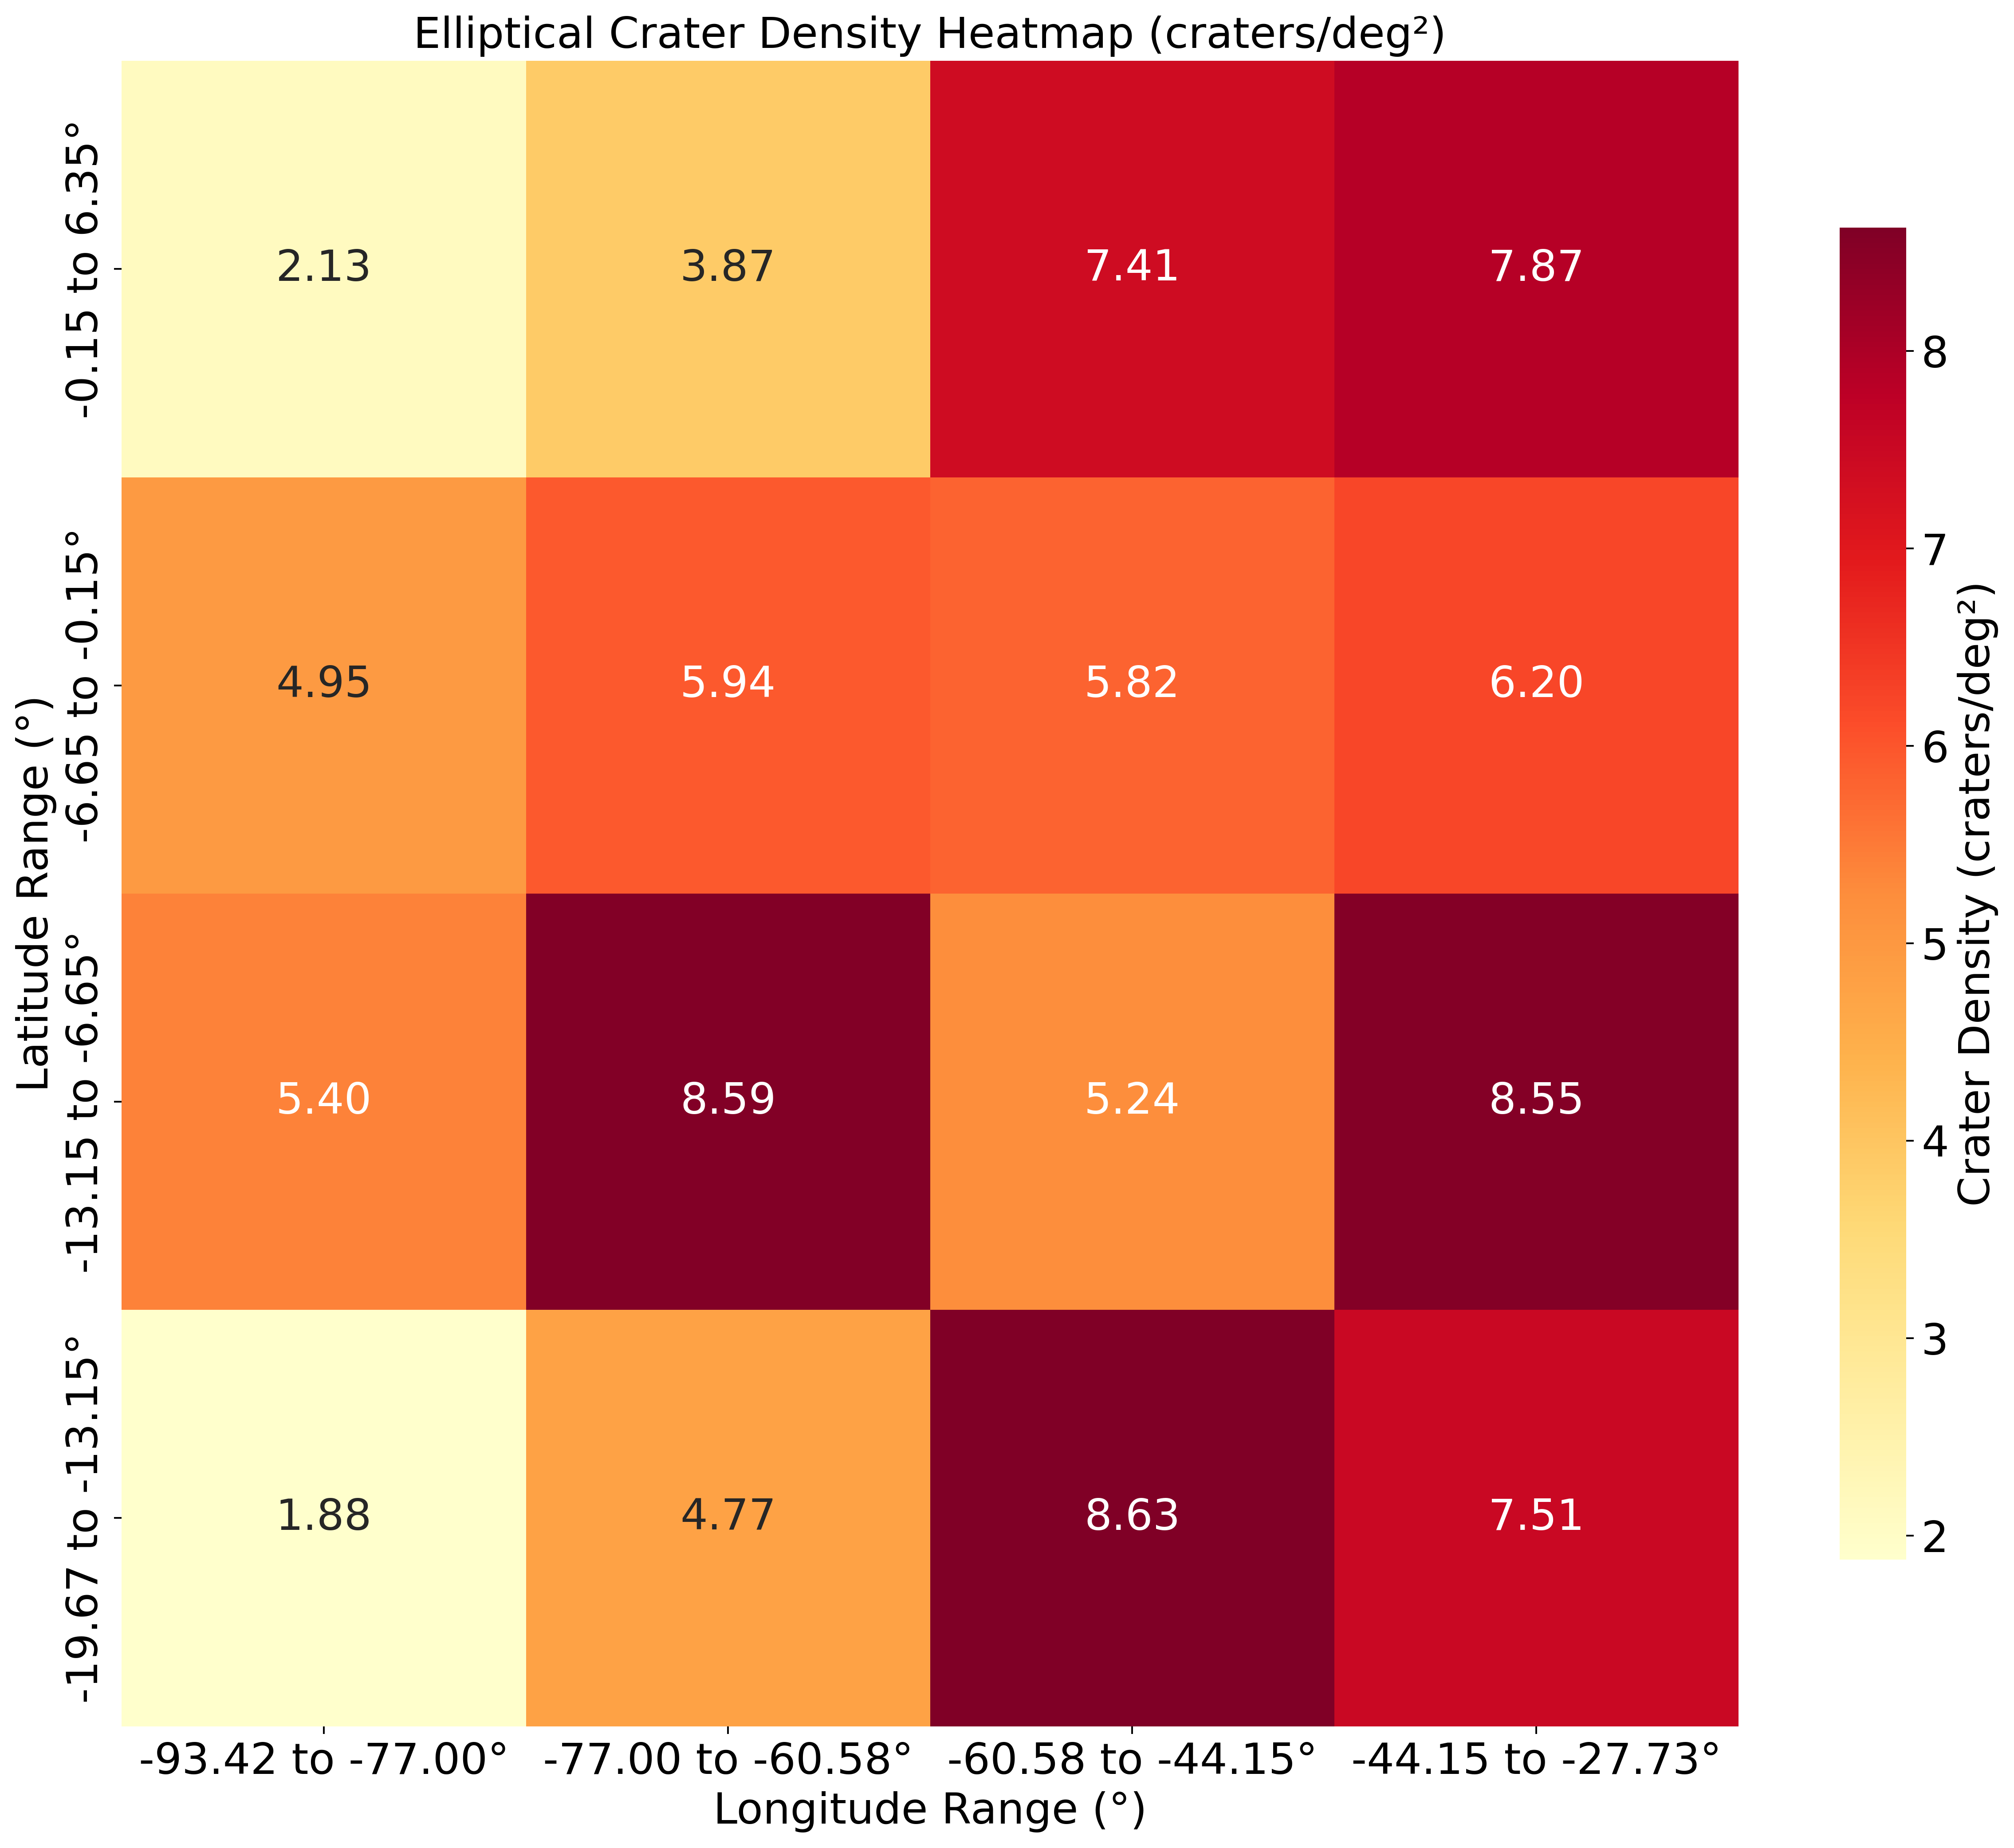

In [44]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns

# Configuration Parameters
IMAGE_PATH = '/content/drive/MyDrive/Planetary/64ppd.png'
RESOLUTION_PPD = 64  # pixels per degree
GRID_ROWS = 4  # Number of rows in the grid
GRID_COLS = 4  # Number of columns in the grid

# Load Image
image = cv2.imread(IMAGE_PATH)
height, width, _ = image.shape

# Define Grid
def define_grid(width, height, rows, cols):
    grid = []
    row_height = height // rows
    col_width = width // cols
    for r in range(rows):
        for c in range(cols):
            x_start = c * col_width
            y_start = r * row_height
            x_end = (c + 1) * col_width if c < cols - 1 else width
            y_end = (r + 1) * row_height if r < rows - 1 else height
            grid.append((x_start, y_start, x_end, y_end))
    return grid

grid = define_grid(width, height, GRID_ROWS, GRID_COLS)

# Function to Preprocess Image
def preprocess_image(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Apply median blur to reduce noise
    blurred = cv2.medianBlur(gray, 5)
    return blurred, gray

# Function to Detect Elliptical Craters
def detect_elliptical_craters(sub_image):
    blur, _ = preprocess_image(sub_image)

    # Find contours in the binary image (Canny edge detection)
    edges = cv2.Canny(blur, 50, 150)

    # Find contours in the edges image
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    ellipses = []

    # Fit ellipses to the contours found
    for contour in contours:
        if len(contour) >= 5:  # At least 5 points needed to fit an ellipse
            ellipse = cv2.fitEllipse(contour)
            ellipses.append(ellipse)  # Ellipse is in (center, axes, angle)

    return ellipses

# Function to Calculate Crater Density
def calculate_crater_density(craters, area):
    return len(craters) / area if craters is not None else 0

# Function to Calculate Area in Degrees
def calculate_area(grid_section):
    # Convert pixel counts to degrees
    x_start, y_start, x_end, y_end = grid_section
    lon_diff = (x_end - x_start) / RESOLUTION_PPD
    lat_diff = (y_end - y_start) / RESOLUTION_PPD
    return lon_diff * lat_diff  # degrees squared

# Initialize Data Structures
crater_data = []

# Iterate Over Grid Sections
for idx, section in enumerate(grid):
    x_start, y_start, x_end, y_end = section
    sub_image = image[y_start:y_end, x_start:x_end]

    # Detect Elliptical Craters
    ellipses = detect_elliptical_craters(sub_image)

    # Calculate Area
    area = calculate_area(section)

    # Calculate Density
    density = calculate_crater_density(ellipses, area)

    # Store Data
    crater_data.append({
        'grid_index': idx,
        'crater_count': len(ellipses),
        'crater_density': density,
        'craters': ellipses
    })

# Example Output
for data in crater_data:
    print(f"Grid {data['grid_index']}: Crater Count = {data['crater_count']}, Density = {data['crater_density']:.2f} craters/deg²")

# Visualizing Crater Density Across the Region

# Lat/Lon coordinates for the grid
top_left = (-93.42, 6.35)
bottom_left = (-93.42, -19.58)
top_right = (27.77, 6.35)
bottom_right = (27.77, -19.58)

# Function to calculate latitude and longitude for grid sections
def calculate_lat_lon_ranges(grid, resolution_ppd):
    lat_lon_ranges = []
    for section in grid:
        x_start, y_start, x_end, y_end = section
        lon_start = top_left[0] + (x_start / resolution_ppd)
        lon_end = top_left[0] + (x_end / resolution_ppd)
        lat_start = top_left[1] - (y_end / resolution_ppd)  # Negative because image Y decreases upwards
        lat_end = top_left[1] - (y_start / resolution_ppd)
        lat_lon_ranges.append((lon_start, lon_end, lat_start, lat_end))
    return lat_lon_ranges

# Calculate latitude and longitude ranges for the heatmap labels
lat_lon_ranges = calculate_lat_lon_ranges(grid, RESOLUTION_PPD)

# Prepare Data for Heatmap
densities = [data['crater_density'] for data in crater_data]  # Use 'crater_density'

# Reshape Data for Heatmap
heatmap_data = np.array(densities).reshape(GRID_ROWS, GRID_COLS)

# Create Heatmap
plt.figure(figsize=(14, 12), dpi=350)  # Increase figure size and set dpi to 350
ax = sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap='YlOrRd',
            xticklabels=[f"{lat_lon_ranges[i][0]:.2f} to {lat_lon_ranges[i][1]:.2f}°" for i in range(GRID_COLS)],
            yticklabels=[f"{lat_lon_ranges[i][2]:.2f} to {lat_lon_ranges[i][3]:.2f}°" for i in range(0, GRID_ROWS * GRID_COLS, GRID_COLS)],
            annot_kws={"size": 20},  # Increase annotation font size
            cbar_kws={"label": "Crater Density (craters/deg²)", 'shrink': 0.8})  # Color bar label and shrink

# Adjusting axis labels and title
plt.title('Elliptical Crater Density Heatmap (craters/deg²)', fontsize=20)
plt.xlabel('Longitude Range (°)', fontsize=20)
plt.ylabel('Latitude Range (°)', fontsize=20)

# Adjust tick parameters for larger font size
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# Adjust the colorbar labels and ticks
cbar = ax.collections[0].colorbar  # Get the colorbar
cbar.set_label('Crater Density (craters/deg²)', fontsize=20)  # Set colorbar label
cbar.ax.tick_params(labelsize=20)  # Set colorbar ticks font size

# Adjust layout to prevent overlap and make the figure look neat
plt.tight_layout()

# Show the plot
plt.show()


Grid 0: Crater Count = 223, Density = 2.09 craters/deg²
Grid 1: Crater Count = 412, Density = 3.86 craters/deg²
Grid 2: Crater Count = 783, Density = 7.34 craters/deg²
Grid 3: Crater Count = 831, Density = 7.79 craters/deg²
Grid 4: Crater Count = 521, Density = 4.88 craters/deg²
Grid 5: Crater Count = 626, Density = 5.86 craters/deg²
Grid 6: Crater Count = 616, Density = 5.77 craters/deg²
Grid 7: Crater Count = 655, Density = 6.14 craters/deg²
Grid 8: Crater Count = 566, Density = 5.30 craters/deg²
Grid 9: Crater Count = 897, Density = 8.40 craters/deg²
Grid 10: Crater Count = 549, Density = 5.14 craters/deg²
Grid 11: Crater Count = 901, Density = 8.44 craters/deg²
Grid 12: Crater Count = 200, Density = 1.87 craters/deg²
Grid 13: Crater Count = 505, Density = 4.72 craters/deg²
Grid 14: Crater Count = 908, Density = 8.49 craters/deg²
Grid 15: Crater Count = 801, Density = 7.49 craters/deg²


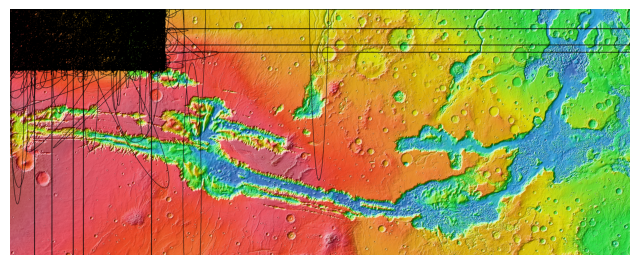

In [45]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def preprocess_image(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Apply median blur to reduce noise
    blurred = cv2.medianBlur(gray, 5)
    return blurred, gray

# Function to detect elliptical craters
def detect_elliptical_craters(sub_image):
    blur, _ = preprocess_image(sub_image)

    # Find contours in the binary image (Canny edge detection)
    edges = cv2.Canny(blur, 50, 150)

    # Find contours in the edges image
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    ellipses = []

    # Fit ellipses to the contours found
    for contour in contours:
        if len(contour) >= 5:  # At least 5 points needed to fit an ellipse
            try:
                ellipse = cv2.fitEllipse(contour)
                # Check if ellipse axes are valid (non-zero and finite)
                if all(np.isfinite(ellipse[1])) and ellipse[1][0] > 0 and ellipse[1][1] > 0:
                    ellipses.append(ellipse)  # Ellipse is in (center, axes, angle)
            except cv2.error:
                # In case of an error fitting an ellipse, skip this contour
                pass

    return ellipses

# Function to calculate crater density
def calculate_crater_density(craters, area):
    return len(craters) / area if craters is not None else 0

# Function to calculate area in degrees
def calculate_area(grid_section):
    # Convert pixel counts to degrees
    x_start, y_start, x_end, y_end = grid_section
    lon_diff = (x_end - x_start) / RESOLUTION_PPD
    lat_diff = (y_end - y_start) / RESOLUTION_PPD
    return lon_diff * lat_diff  # degrees squared

# Configuration Parameters
IMAGE_PATH = '/content/drive/MyDrive/Planetary/64ppd.png'
RESOLUTION_PPD = 64  # pixels per degree
GRID_ROWS = 4  # Number of rows in the grid
GRID_COLS = 4  # Number of columns in the grid

# Load Image
image = cv2.imread(IMAGE_PATH)
height, width, _ = image.shape

# Define Grid
def define_grid(width, height, rows, cols):
    grid = []
    row_height = height // rows
    col_width = width // cols
    for r in range(rows):
        for c in range(cols):
            x_start = c * col_width
            y_start = r * row_height
            x_end = (c + 1) * col_width if c < cols - 1 else width
            y_end = (r + 1) * row_height if r < rows - 1 else height
            grid.append((x_start, y_start, x_end, y_end))
    return grid

grid = define_grid(width, height, GRID_ROWS, GRID_COLS)

# Initialize Data Structures
crater_data = []

# Iterate Over Grid Sections
for idx, section in enumerate(grid):
    x_start, y_start, x_end, y_end = section
    sub_image = image[y_start:y_end, x_start:x_end]

    # Detect Elliptical Craters
    ellipses = detect_elliptical_craters(sub_image)

    # Calculate Area
    area = calculate_area(section)

    # Calculate Density
    density = calculate_crater_density(ellipses, area)

    # Store Data
    crater_data.append({
        'grid_index': idx,
        'crater_count': len(ellipses),
        'crater_density': density,
        'craters': ellipses
    })

# Output results
for data in crater_data:
    print(f"Grid {data['grid_index']}: Crater Count = {data['crater_count']}, Density = {data['crater_density']:.2f} craters/deg²")

# Visualize detected elliptical craters by overlaying them
output = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert image to RGB for plotting

# Iterate through the detected craters and overlay ellipses
for data in crater_data:
    ellipses = data.get('craters')  # Get the list of ellipses for each grid section
    if ellipses:
        for ellipse in ellipses:
            # Draw ellipses on the output image only if axes are valid
            center, axes, angle = ellipse
            axes = (int(axes[0] / 2), int(axes[1] / 2))  # Adjust size for visualization
            if axes[0] > 0 and axes[1] > 0:  # Ensure valid axes
                cv2.ellipse(output, (int(center[0]), int(center[1])), axes, angle, 0, 360, (0, 0, 0), 2)

# Show the image with overlaid ellipses
plt.figure(figsize=(8, 6))
plt.imshow(output)
plt.axis('off')  # Hide axes for better visualization
plt.show()